In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
import math
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from __future__ import division, print_function
from scipy.ndimage import rotate
import glob
!pip install pydicom
!pip install mahotas
import mahotas
import cv2
import pydicom


     |████████████████████████████████| 35.5MB 94kB/s 
     |████████████████████████████████| 5.7MB 4.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Following 2 block cells are for data generation and needs to be run only once. After that we can directly load the data from the google drive on each runtime.
Create a folder named saved to store the inputs and output

In [ ]:
path1 = "/content/drive/My Drive/782dataset/TrainingSet/patient"
flag = 0
counter = 0
for i in range(1,17):
  path2 = path1 + str(i).zfill(2)
  path3 = path2 + "/P" + str(i).zfill(2) + "contours-manual"
  path4 = path2 + "/P" + str(i).zfill(2) + "dicom"
  for files in sorted(os.listdir(path3)):
    dir = files[0:8]
    path5 = path4 + "/" + dir + ".dcm"
    path6 = path3 + "/" + files
    #print(path6)
    e = pydicom.filereader.dcmread(path5)
    if (counter%2==0):
      X = e.pixel_array
      #X[X >= 255] = 255
      #X = X/np.amax(X)
      #print(X.shape)
      if((len(e.pixel_array)==256) & (len(e.pixel_array[0])==216)):
        X = rotate(X,90)
        #print("ulta")
      X = X.reshape(1,1,216,256)
      if (flag==0):
        train_i = X
      else :
        train_i = np.concatenate((train_i,X),axis=0)
    data = np.genfromtxt(path6, delimiter=' ')
    ps = e.PixelSpacing
    data = np.round(data)
    data = data.astype(int)
    if ((len(e.pixel_array)==216) & (len(e.pixel_array[0])==256)):
      mask = np.array(np.zeros((256,216)))
      mahotas.polygon.fill_polygon(data,mask,color=1)
      mask = rotate(mask,90)
      #print("seedha")
    else :
      mask = np.array(np.zeros((216,256)))
      mahotas.polygon.fill_polygon(data,mask,color=1)
      #print("ulta2")
    mask = np.flip(mask,0)
    mask = mask.reshape(1,1,216,256)
    if (flag==0):
      train_o = mask
    else :
      train_o = np.concatenate((train_o,mask),axis=0)
    flag=1
    counter+=1

print(train_i.shape) 
print(train_o.shape)


input_vector = np.zeros((243,1,216,256))
clahe = cv2.createCLAHE(clipLimit =255.0, tileGridSize=(3,3))
for i in range(0,243):
    cl_img = clahe.apply(train_i[i,0,:,:])
    cl_img = cl_img*(1.0/np.amax(cl_img))
    input_vector[i,0,:,:] = cl_img


y = np.zeros((243,2,216,256))
for i in range(0,486):
    if (i%2==0):
        y[int(i/2),0,:,:] = train_o[i,0,:,:]
    else:
        y[int(i/2),1,:,:] = train_o[i,0,:,:]
print(y.shape)
print(input_vector.shape)
train_o = y
train_o[train_o <= 0] = 0
train_o[train_o >= 1] = 1


#np.save(os.path.join('/content/drive/My Drive/782dataset/saved','train_o'),train_o)
#np.save(os.path.join('/content/drive/My Drive/782dataset/saved','input_vector'),input_vector)



In [ ]:

path0 = "/content/drive/My Drive/782dataset/Test2/Test2Set/patient"
path1 = "/content/drive/My Drive/782dataset/Test2/Test2SetContours/P"
flag = 0
counter = 0
for i in range(33,49):
  #path2 = path1 + str(i).zfill(2)
  path3 = path1 + str(i).zfill(2) + "contours-manual"
  path4 = path0 + str(i).zfill(2) + "/P" + str(i).zfill(2) + "dicom"
  #print(path3)
  for files in sorted(os.listdir(path3)):
    dir = files[0:8]
    path5 = path4 + "/" + dir + ".dcm"
    path6 = path3 + "/" + files
    #print(path6)
    e = pydicom.filereader.dcmread(path5)
    if (counter%2==0):
      X = e.pixel_array
      #print(X.shape)
      if((len(e.pixel_array)==256) & (len(e.pixel_array[0])==216)):
        X = rotate(X,90)
        #print("ulta")
      X = X.reshape(1,1,216,256)
      if (flag==0):
        test2_i = X
      else :
        test2_i = np.concatenate((test2_i,X),axis=0)
    data = np.genfromtxt(path6, delimiter=' ')
    ps = e.PixelSpacing
    data = np.round(data)
    data = data.astype(int)
    if ((len(e.pixel_array)==216) & (len(e.pixel_array[0])==256)):
      mask = np.array(np.zeros((256,216)))
      mahotas.polygon.fill_polygon(data,mask,color=1)
      mask = rotate(mask,90)
      #print("seedha")
    else :
      mask = np.array(np.zeros((216,256)))
      mahotas.polygon.fill_polygon(data,mask,color=1)
      #print("ulta2")
    mask = np.flip(mask,0)
    mask = mask.reshape(1,1,216,256)
    if (flag==0):
      test2_o = mask
    else :
      test2_o = np.concatenate((test2_o,mask),axis=0)
    flag=1
    counter+=1


print(test2_i.shape) 
print(test2_o.shape)



y = np.zeros((252,2,216,256))
for i in range(0,504):
  if (i%2==0):
    y[int(i/2),0,:,:] = test2_o[i,0,:,:]
  else:
    y[int(i/2),1,:,:] = test2_o[i,0,:,:]
print(y.shape)
test2_o = y
test2_o[test2_o <= 0] = 0
test2_o[test2_o >= 1] = 1



input_vector2 = np.zeros((252,1,216,256)) ##image with values within 0-255
clahe = cv2.createCLAHE(clipLimit =255.0, tileGridSize=(3,3))
for i in range(0,252):
    cl_img = clahe.apply(test2_i[i,0,:,:])
    cl_img = cl_img*(1.0/np.amax(cl_img))
    input_vector2[i,0,:,:] = cl_img

test2_length = input_vector2.shape[0]
#print(np.amax(input_vector2))
#plt.imshow((input_vector2[24,0,:,:]),cmap = 'gray')
#print(input_vector2.shape)



#np.save(os.path.join('/content/drive/My Drive/782dataset/saved','test2_o'),test2_o)
#np.save(os.path.join('/content/drive/My Drive/782dataset/saved','input_vector2'),input_vector2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
p_for_dropout = 0.2
#dont know the activation function in last layer, currently no activation function used after final 1x1 conv

class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=(3,3), padding=(1,1)):
        block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=1),
                nn.Dropout2d(p=p_for_dropout,inplace=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
                )
        return block

    def bottle_neck(self, in_channels, out_channels, kernel_size=(3,3), padding=(1,1)):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.Dropout2d(p=p_for_dropout,inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.Dropout2d(p=p_for_dropout,inplace=True),
            nn.ReLU(inplace=True)
            
        )
        return block
    
    def expansive_block(self, in_channels, out_channels, kernel_size=(3,3), padding=(1,1)):
        block = nn.Sequential(
                #nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=padding),
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding),
                nn.Dropout2d(p=p_for_dropout,inplace=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
                #nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1)
                )
        return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_encode3 = self.contracting_block(128, 256)
        #self.conv_encode4 = self.contracting_block(64, 128)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        
        self.neck = self.bottle_neck(256, 512)

        self.upsample = nn.Upsample(scale_factor=2)
        self.upconv1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=(1,1))
        self.upconv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=1, padding=(1,1))
        self.upconv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=(1,1))

        # Decode
        #self.conv_decode5 = self.expansive_block(256, 128)
        #self.conv_decode4 = self.expansive_block(256, 64)
        self.conv_decode3 = self.expansive_block(512, 256)
        self.conv_decode2 = self.expansive_block(256, 128)
        self.conv_decode1 = self.expansive_block(128, 64)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=out_channel, kernel_size=(1,1), stride=1, padding=(0,0))
        self.sigmoid = nn.Sigmoid()
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x) #(128, 108, 64)
        encode_block2 = self.conv_encode2(self.max_pool(encode_block1)) #(64, 54, 128)
        encode_block3 = self.conv_encode3(self.max_pool(encode_block2)) #(32, 27, 256)
        neck = self.neck(self.max_pool(encode_block3)) #(32, 27, 512)
        #encode_block4 = self.conv_encode4(encode_block3)
        #encode_block5 = self.conv_encode5(encode_block4)
        
        # Decode
        decode_block3 = self.upconv1(self.upsample(neck)) #(64, 54, 256)
        #print(decode_block3.size(), encode_block3.size())
        decode_block3 = self.conv_decode3(self.crop_and_concat(decode_block3, encode_block3, crop=False)) #(64, 54, 256)
        decode_block2 = self.upconv2(self.upsample(decode_block3)) #(128, 108, 128)
        decode_block2 = self.conv_decode2(self.crop_and_concat(decode_block2, encode_block2, crop=False)) #(128, 108, 128)
        decode_block1 = self.upconv3(self.upsample(decode_block2)) #(256, 216, 64)
        decode_block1 = self.conv_decode1(self.crop_and_concat(decode_block1, encode_block1, crop=False)) #(256, 216, 64)
        final_output = self.final_conv(decode_block1)
        return  self.sigmoid(final_output)

cuda


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=1, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        smooth = 1    
        iflat = inputs.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets):
        #inputs = F.sigmoid(inputs)  
        smooth = 1     
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + 0.5*dice_loss
        return Dice_BCE


#ALPHA = 0.5
#BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, alpha = 0.5, beta = 0.5, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, alpha, beta):
        smooth = 1
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        return 1 - Tversky


class InvertedDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(InvertedDiceLoss, self).__init__()

    def forward(self, inputs, targets):
        smooth = 1    
        iflat = inputs.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        intersection = ((1-iflat) * (1-tflat)).sum()
        A_sum = torch.sum((1-iflat) * (1-iflat))
        B_sum = torch.sum((1-tflat) * (1-tflat))
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))


loss_dice = DiceLoss()
loss_dice = loss_dice.to(device)

loss_focal = FocalLoss(gamma=1.5)
loss_focal = loss_focal.to(device)

loss_diceBCE = DiceBCELoss()
loss_diceBCE = loss_diceBCE.to(device)

loss_tversky = TverskyLoss()
loss_tversky = loss_tversky.to(device)

loss_inverted_dice = InvertedDiceLoss()
loss_inverted_dice = loss_inverted_dice.to(device)

In [ ]:
input_vector = np.load(os.path.join('/content/drive/My Drive/782dataset/saved','input_vector.npy'))
train_o = np.load(os.path.join('/content/drive/My Drive/782dataset/saved','train_o.npy'))

percentage_data = int(1*243)

train_i = torch.from_numpy(input_vector[0:percentage_data,:,:,:])
train_o = torch.from_numpy(train_o[0:percentage_data,:,:,:])
print(train_i.shape)
print(train_o.shape)




model = UNet(1, 2)
model = model.to(device)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_parameters)

torch.Size([243, 1, 216, 256])
torch.Size([243, 2, 216, 256])
7009026


In [ ]:
learning_rate = 1e-4
lambda1 = 0.00000001
model_name = 'model_BCEdice_dropout_l1-l2_dict_ep'
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 60, 70, 80, 90], gamma=0.8)

batch_size = 16
dataset_size = train_i.size()[0]
n_batches = int(dataset_size/batch_size)
#trainloader = DataLoader((train_i, train_o), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
training_losses = []
#print(dataset_size)



print(device)
for epoch in range(0, 100):  # loop over the dataset multiple times

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    running_train_loss = 0.0
    #running_val_loss = 0.0
    num_batches = 0
    for i in range(n_batches):

        train_i_mini, train_o_mini = train_i[i*batch_size:(i+1)*batch_size,:,:,:], train_o[i*batch_size:(i+1)*batch_size,:,:,:]
        train_i_mini, train_o_mini = train_i_mini.to(device), train_o_mini.to(device)
        train_i_mini = train_i_mini.float()
        train_o_mini = train_o_mini.float()
        num_batches += 1

        # zero the parameter gradients
        optimizer.zero_grad()
        output_masks = model(train_i_mini)

        #L1 regularization
        l1_regularization = 0
        for param in model.parameters():
          l1_regularization += torch.norm(param, 1)**2
        l1_regularization = l1_regularization*lambda1

    
        train_loss = loss_diceBCE(output_masks, train_o_mini) + l1_regularization
        #train_loss = loss_tversky(output_masks, train_o_mini,alpha = 0.7, beta = 0.3)+ l1_regularization
        train_loss.backward()
        optimizer.step()

        running_train_loss += train_loss.item()
    end_event.record()
    torch.cuda.synchronize()  # Wait for the events to be recorded!
    elapsed_time_ms = start_event.elapsed_time(end_event)
    training_losses.append(running_train_loss/num_batches)
    #val_losses.append(running_val_loss/len(reverb_val_dataset))
    #scheduler.step()

    #if (epoch % 10 == 0):
    #    path = '/content/drive/My Drive/Summer_2020/models/model_v11_ep' + str(epoch) + '.pth'
    #    torch.save(model.state_dict(), path)

    print("epoch no. =", (epoch), ", time taken =", "{:.2f},".format(elapsed_time_ms/1000), "avg. train loss =", "{:.7f}".format(running_train_loss/num_batches))

print('Finished Training')
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())
path = '/content/drive/My Drive/782dataset/models/'+ model_name + str(epoch) + '.tar'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': training_losses,
            }, path)


cuda
epoch no. = 0 , time taken = 7.07, avg. train loss = 6.6714191
epoch no. = 1 , time taken = 7.13, avg. train loss = 4.9989624
epoch no. = 2 , time taken = 7.22, avg. train loss = 3.8306797
epoch no. = 3 , time taken = 7.31, avg. train loss = 3.0416397
epoch no. = 4 , time taken = 7.39, avg. train loss = 2.5077613
epoch no. = 5 , time taken = 7.33, avg. train loss = 2.1467217
epoch no. = 6 , time taken = 7.24, avg. train loss = 1.8988703
epoch no. = 7 , time taken = 7.17, avg. train loss = 1.7227920
epoch no. = 8 , time taken = 7.13, avg. train loss = 1.6013874
epoch no. = 9 , time taken = 7.09, avg. train loss = 1.5095228
epoch no. = 10 , time taken = 7.09, avg. train loss = 1.4402161
epoch no. = 11 , time taken = 7.11, avg. train loss = 1.3880316
epoch no. = 12 , time taken = 7.13, avg. train loss = 1.3472668
epoch no. = 13 , time taken = 7.16, avg. train loss = 1.3129225
epoch no. = 14 , time taken = 7.19, avg. train loss = 1.2871945
epoch no. = 15 , time taken = 7.21, avg. trai

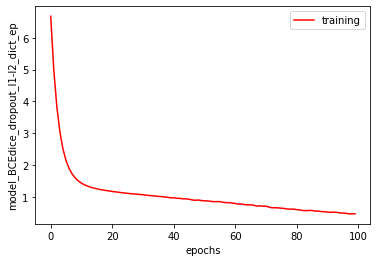

In [ ]:
x = list(range(0, epoch+1))
plt.plot(x, training_losses, color='red', label='training')
#plt.plot(x, val_losses, color='green', label='validation')
plt.xlabel('epochs')
plt.ylabel(model_name)
plt.legend()
path = '/content/drive/My Drive/782dataset/models/'+ model_name + str(epoch) + '.png'
plt.savefig(path)
plt.show()


In [ ]:
#loading the model
model = UNet(1, 2)
#model = model.to(device)
path = '/content/drive/My Drive/782dataset/models/'+ model_name + str(epoch) + '.tar'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']



#TESTING
#dice coefficient

input_vector2 = np.load(os.path.join('/content/drive/My Drive/782dataset/saved','input_vector2.npy'))
test2_o = np.load(os.path.join('/content/drive/My Drive/782dataset/saved','test2_o.npy'))
test2_length = input_vector2.shape[0]
model.to(device)
model.eval()


avg_dice_endo = 0.0
avg_dice_epi = 0.0

for i in range(test2_length):
    if (i%50 == 0):
        print(i)
    test_image, test_target = torch.from_numpy(input_vector2[i,:,:,:]).to(device), torch.from_numpy(test2_o[i,:,:,:]).to(device)
    test_output = model(torch.unsqueeze(test_image.float(), dim=0))
    test_output[test_output >= 0.5] = 1
    test_output[test_output <= 0.5] = 0
    test_output_endo, test_output_epi = test_output[:,0,:,:], test_output[:,1,:,:]
    test_target_endo, test_target_epi = torch.unsqueeze(test_target[0,:,:], dim=0), torch.unsqueeze(test_target[1,:,:], dim=0)
    dice_endo = torch.sum(test_output_endo[test_target_endo==1])*2.0 / (torch.sum(test_output_endo) + torch.sum(test_target_endo))
    dice_epi = torch.sum(test_output_epi[test_target_epi==1])*2.0 / (torch.sum(test_output_epi) + torch.sum(test_target_epi))
    avg_dice_endo += dice_endo.item()
    avg_dice_epi += dice_epi.item()

avg_dice_endo = avg_dice_endo/test2_length
avg_dice_epi = avg_dice_epi/test2_length
print("Dice score on test2 dataset (endocardium) =", avg_dice_endo)
print("Dice score on test2 dataset (epicardium) =", avg_dice_epi)

0
50
100
150
200
250
Dice score on test2 dataset (endocardium) = 0.637607781154473
Dice score on test2 dataset (epicardium) = 0.6563688696189695
